In [36]:
import numpy as np
import pandas as pd
import cPickle
from collections import defaultdict
import re

import gensim

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import time


from sklearn.decomposition import TruncatedSVD

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import Adadelta
from keras.constraints import unitnorm
from keras.regularizers import l2
from keras.utils import np_utils
from keras import callbacks

import lda

import matplotlib.pyplot as plt

from __future__ import division
%matplotlib inline

# load data

In [74]:
df0_train_s = pd.read_pickle('../data/df0_train_s_ue0.pkl')
df0_test_s = pd.read_pickle('../data/df0_test_s_ue0.pkl')

# cluster2vec

In [61]:
# load model_word2vec
model_word2vec = gensim.models.Word2Vec.load("../model/model_word2vec.model")

In [39]:
# cluster

#num_clusters = word_vectors.shape[0] / 5    #需要自己设置，将K设置的大一些，提高效果
num_clusters = 10


# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model_word2vec.syn0
print 'word_vectors shape:',word_vectors.shape

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

word_vectors shape: (84543L, 500L)


In [45]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model_word2vec.index2word, idx ))

In [69]:
def create_bag_of_centroids( text, word_centroid_map ):
    wordlist = text.split()
    #
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    #
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    #
    # Return the "bag of centroids"
    return bag_of_centroids

In [76]:
df0_train_s['cluster'] = df0_train_s['text'].apply(lambda x:create_bag_of_centroids(x,word_centroid_map))
df0_test_s['cluster'] = df0_test_s['text'].apply(lambda x:create_bag_of_centroids(x,word_centroid_map))

# cluster2vec+ue

In [79]:
select_cols = [u'pos_num', u'neg_num', u'pos', u'ef0', u'ef1', u'ef2', u'ef3', u'ef4', u'ef5', u'ef6', u'ef7', u'ef8', u'ef9']

train_x = np.c_[df0_train_s[select_cols].values, np.array((df0_train_s['cluster']).tolist())]
train_y = np.array(df0_train_s['polarity'])

test_x =  np.c_[df0_test_s[select_cols].values, np.array((df0_test_s['cluster']).tolist())]
test_y = np.array(df0_test_s['polarity'])

print 'train_x shape:',train_x.shape
print 'train_y shape:',train_y.shape

print 'test_x shape:',test_x.shape
print 'test_y shape:',test_y.shape

train_x shape: (5000L, 23L)
train_y shape: (5000L,)
test_x shape: (5000L, 23L)
test_y shape: (5000L,)


# BENCHMARK

In [80]:
## SVM
model_svm = SVC()
model_svm.fit(train_x,train_y)

print 'Traing Accuracy:',model_svm.score(train_x,train_y)
print 'Testing Accuracy:',model_svm.score(test_x,test_y)

Traing Accuracy: 0.7238
Testing Accuracy: 0.6756


In [81]:
## LR
model_lr = LogisticRegression()
model_lr.fit(train_x,train_y)

print 'Traing Accuracy:',model_lr.score(train_x,train_y)
print 'Testing Accuracy:',model_lr.score(test_x,test_y)

Traing Accuracy: 0.6908
Testing Accuracy: 0.6742


In [82]:
##RF

model_rf = RandomForestClassifier()
model_rf.fit(train_x,train_y)
print 'Traing Accuracy:',model_rf.score(train_x,train_y)
print 'Testing Accuracy:',model_rf.score(test_x,test_y)

Traing Accuracy: 0.9808
Testing Accuracy: 0.6466


# MODEL BUILDING

In [83]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def get_test_acc(test_x_cat,test_y,model):
    p1 = model.predict_proba(test_x_cat)
    return np.mean(test_y==(np.argmax(p1,axis=1)))
    
%matplotlib inline

In [89]:
train_y_cat = np_utils.to_categorical(train_y)
test_y_cat = np_utils.to_categorical(test_y)

train_x_cat = train_x.reshape(train_x.shape[0],1,train_x.shape[1],1)
test_x_cat = test_x.reshape(test_x.shape[0],1,test_x.shape[1],1)

In [93]:
from keras.optimizers import SGD

sgd = SGD()

model_cnn = Sequential()
model_cnn.add(Convolution2D(10, 5, 1,border_mode="valid",activation="relu",input_shape=(1, train_x.shape[1], 1)))
model_cnn.add(MaxPooling2D(pool_size=(2,1)))
model_cnn.add(Flatten())
model_cnn.add(Dense(10))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(2))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=['accuracy'])

In [94]:
model_cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_2 (Convolution2D)  (None, 10, 19L, 1)    60          convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 10, 9L, 1)     0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 90)            0           maxpooling2d_2[0][0]             
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 10)            910         flatten_2[0][0]                  
___________________________________________________________________________________________

# model training

In [95]:
history = model_cnn.fit(train_x_cat,train_y_cat,nb_epoch=300,validation_split=0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/300
4000/4000 [==============================] - 0s - loss: 0.7112 - acc: 0.5330 - val_loss: 0.6719 - val_acc: 0.6470
Epoch 2/300
4000/4000 [==============================] - 0s - loss: 0.6802 - acc: 0.5667 - val_loss: 0.6673 - val_acc: 0.6680
Epoch 3/300
4000/4000 [==============================] - 0s - loss: 0.6788 - acc: 0.5692 - val_loss: 0.6635 - val_acc: 0.6800
Epoch 4/300
4000/4000 [==============================] - 0s - loss: 0.6735 - acc: 0.5692 - val_loss: 0.6579 - val_acc: 0.6760
Epoch 5/300
4000/4000 [==============================] - 0s - loss: 0.6668 - acc: 0.5803 - val_loss: 0.6505 - val_acc: 0.6810
Epoch 6/300
4000/4000 [==============================] - 0s - loss: 0.6633 - acc: 0.5890 - val_loss: 0.6469 - val_acc: 0.6820
Epoch 7/300
4000/4000 [==============================] - 0s - loss: 0.6597 - acc: 0.6135 - val_loss: 0.6385 - val_acc: 0.6850
Epoch 8/300
4000/4000 [==============================] - 0s - loss: 0.

# MODEL EVALUATION

In [96]:
%matplotlib inline
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

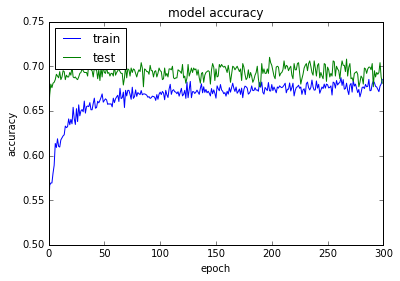

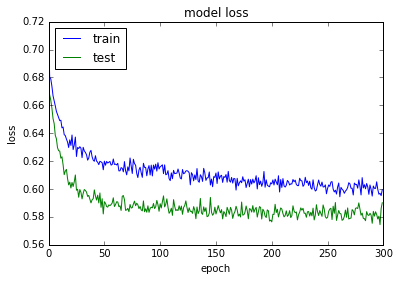

In [97]:
plot_history(history)

# MODEL EVALUATION

In [99]:
get_test_acc(test_x_cat,test_y,model_cnn)

4928/5000 [============================>.] - ETA: 0s

0.66100000000000003